In [9]:
from plot import (
    read_results, 
    combine_results,
    get_experimental_data,
    get_absolute_dGs
)
from functions import (
    read_protocol
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (
    spearmanr,
    pearsonr, 
    bootstrap
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    root_mean_squared_error
)

In [41]:
def compute_rmse(true, predicted):
    return root_mean_squared_error(true, predicted)

def compute_mae(true, predicted):
    return mean_absolute_error(true, predicted)

def compute_r2_score(true, predicted):
    return r2_score(true, predicted)

def compute_pearsonr(true, predicted):
    return pearsonr(true, predicted)[0]

def compute_spearmanrho(true, predicted):
    return spearmanr(true, predicted)[0]

def compute_statistic(experimental_samples, calculated_samples, statistic):
    if statistic.lower() == "rmse":
        statistic = root_mean_squared_error(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "mae":
        statistic = mean_absolute_error(y_true=experimental_samples, y_pred=calculated_samples)
    
    elif statistic.lower() == "r2":
        statistic = r2_score(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "pearson":
        statistic = pearsonr(x=experimental_samples, y=calculated_samples)[0]
    
    elif statistic.lower() == "rho":
        statistic = spearmanr(a=experimental_samples, b=calculated_samples)[0]
    return statistic

def bootstrap_manual(experimental, calculated,  statistic, n_bootstrap_samples=1000, ci=0.95):
    sample_size = len(experimental)
    assert sample_size == len(calculated), f"Calculated ({len(calculated)}) and experimental ({sample_size}) lengths do not match"
    
    bootstrapped_data = np.zeros(
        [n_bootstrap_samples], np.float64
    ) 
    experimental_bootstraps = []
    calculated_bootstraps = []
    for i in range(n_bootstrap_samples):
        if i==0:
            experimental_samples = experimental

            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(sample_size), size = sample_size, replace=True)
            experimental_samples = [experimental[i] for i in bootstrap_sample]

            calculated_samples = [calculated[i] for i in bootstrap_sample]
        
        experimental_bootstraps.append(experimental_samples)
        calculated_bootstraps.append(calculated_samples)
        bootstrapped_data[i] = compute_statistic(experimental_samples, 
                                                 calculated_samples,
                                                 statistic)
    mean = np.mean(bootstrapped_data)
    lower_fraction = ((1 - ci)/2.0) * 100

    upper_fraction = 100 - lower_fraction

    lower_bound = np.percentile(bootstrapped_data, lower_fraction)
    upper_bound = np.percentile(bootstrapped_data, upper_fraction)
    return np.array(experimental_bootstraps), np.array(calculated_bootstraps), bootstrapped_data, mean, lower_bound, upper_bound

def plot_hist(data, n_bins=100):
    plt.hist(data, bins=n_bins, edgecolor="black")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Model 1

In [35]:
working_directory = "/home/jguven/projects/alchemistry/model_1_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"

In [36]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-0.571977,0.143196
1,ligand_6,-8.354581,0.072703,0.353213,0.073940
2,ligand_8,-7.524502,0.018065,-0.969830,0.083567
3,ligand_9,-8.127579,0.079488,-0.457843,0.070890
4,ligand_10,-7.524502,0.005420,-1.082885,0.085610
5,ligand_11,-7.129619,0.003726,-0.330954,0.079446
6,ligand_12,-7.035065,0.001590,1.713554,0.267394
7,ligand_13,-7.506705,0.005260,0.011349,0.076265
8,ligand_15,-6.202678,0.062961,2.906903,0.110250
9,ligand_16,-8.923058,0.028299,-1.571528,0.073917


In [37]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
experimental_values = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")

### Pearson r

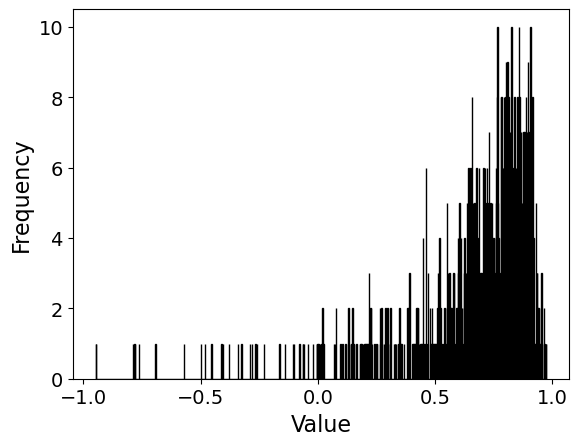

mean: 0.6641230987251477
lower: 0.24995368912845597
upper: 0.8988167275141539


In [20]:
pearsonr_bootstrap_results = bootstrap(data=(experimental_values, calculated_values),
                                       statistic=compute_pearsonr,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True,
                                       confidence_level=0.83)
distribution = pearsonr_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution)
confidence_interval = pearsonr_bootstrap_results.confidence_interval
plot_hist(distribution, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function:**

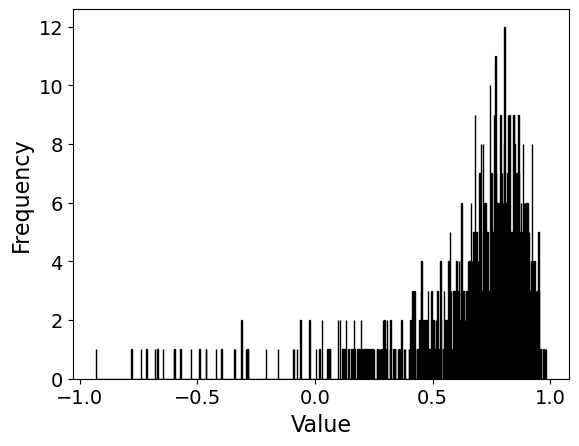

mean: 0.6757187414981912
lower: -0.09624157138389033
upper: 0.9405090739648054


In [42]:
exp_samples, calc_samples, pearson_distr, pearson, pearson_low, pearson_high = bootstrap_manual(experimental=experimental_values,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

In [43]:
exp_samples

array([[-7.79395811, -8.35458119, -7.52450208, ..., -7.5067049 ,
        -6.20267825, -8.92305801],
       [-8.35458119, -8.35458119, -7.5067049 , ..., -7.12961944,
        -8.12757937, -7.12961944],
       [-7.52450208, -8.35458119, -7.12961944, ..., -7.52450208,
        -7.79395811, -7.52450208],
       ...,
       [-7.12961944, -7.79395811, -8.35458119, ..., -8.35458119,
        -7.03506527, -7.52450208],
       [-8.92305801, -7.79395811, -8.12757937, ..., -7.52450208,
        -7.52450208, -6.20267825],
       [-7.52450208, -8.92305801, -7.5067049 , ..., -7.79395811,
        -7.12961944, -7.03506527]])

In [44]:
calc_samples.shape

(1000, 10)

In [66]:
pearson_distr

array([ 0.74175505,  0.4465113 ,  0.52208488,  0.94975558,  0.30582449,
        0.90476111,  0.7659505 ,  0.84568499,  0.8250631 ,  0.54810213,
        0.70772256,  0.75040148,  0.567075  ,  0.7667719 ,  0.70453724,
        0.75214447,  0.90021966,  0.67505936,  0.7163212 ,  0.87549577,
        0.63772171,  0.66855033,  0.85715019,  0.43319848,  0.73224062,
        0.89989755,  0.59190291,  0.66747368,  0.53013083,  0.40645336,
        0.27123717,  0.19001516,  0.81447276,  0.90800948,  0.78690217,
        0.91128028,  0.23535402,  0.56764829,  0.6449447 , -0.31219347,
        0.45261225,  0.91246744,  0.81899917,  0.81651737,  0.68640316,
        0.46697929,  0.60042507,  0.80362909,  0.70591909,  0.36520616,
        0.93317673,  0.69941286,  0.1414334 ,  0.67569399,  0.82156694,
        0.89262635,  0.55683003,  0.61489109,  0.8777801 ,  0.26540407,
        0.89939906,  0.57609056,  0.48658138,  0.77713547,  0.79580348,
        0.41236771,  0.88851739,  0.7685337 ,  0.87557294, -0.08

In [70]:
pearson_distr.shape

(1000,)

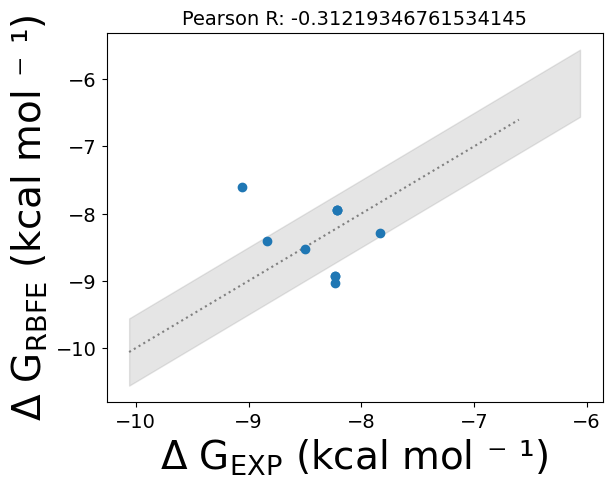

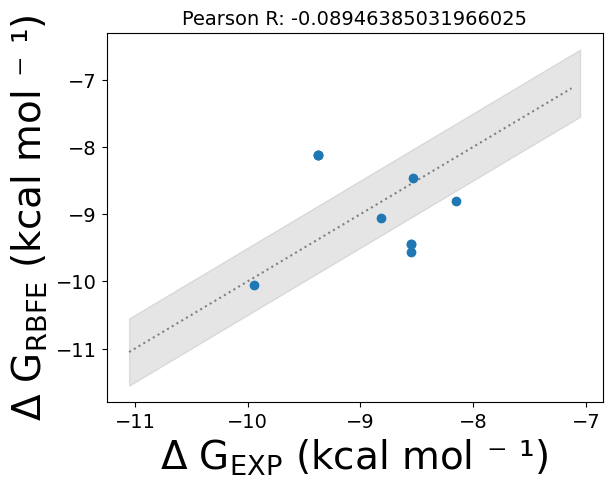

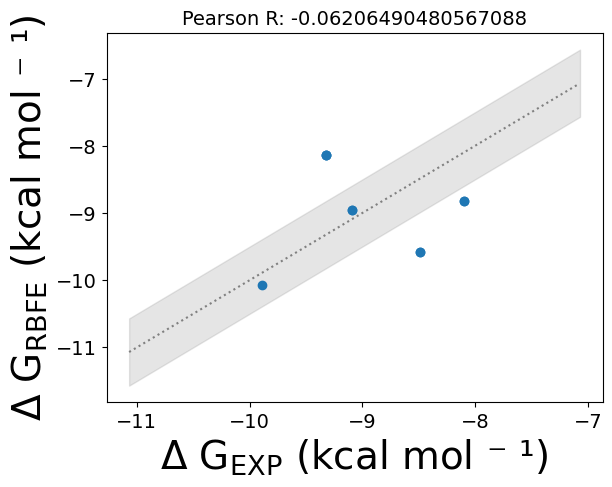

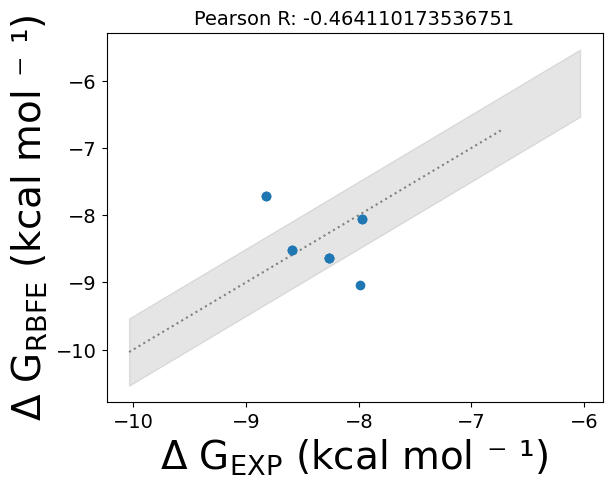

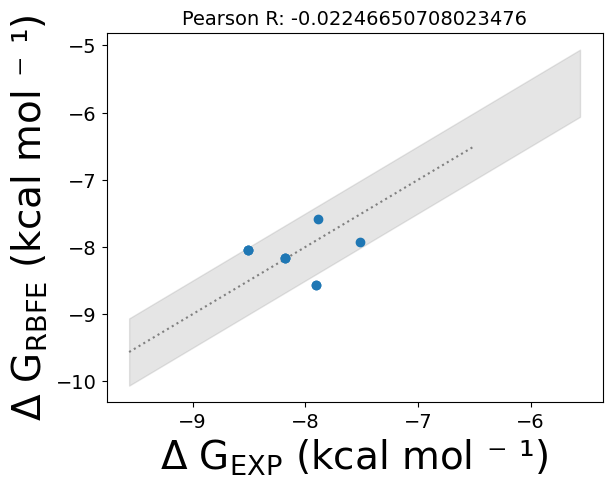

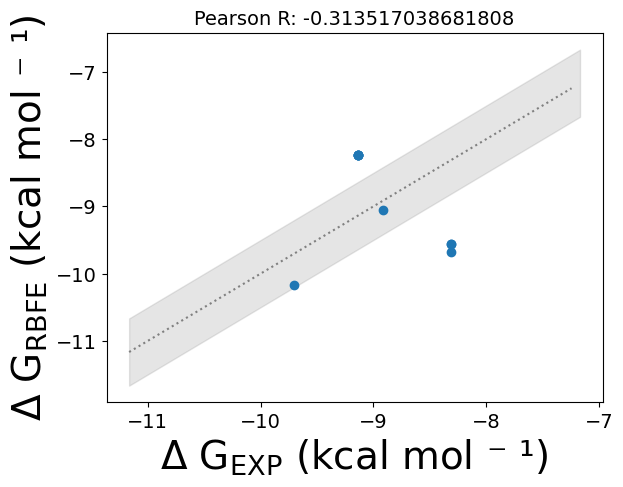

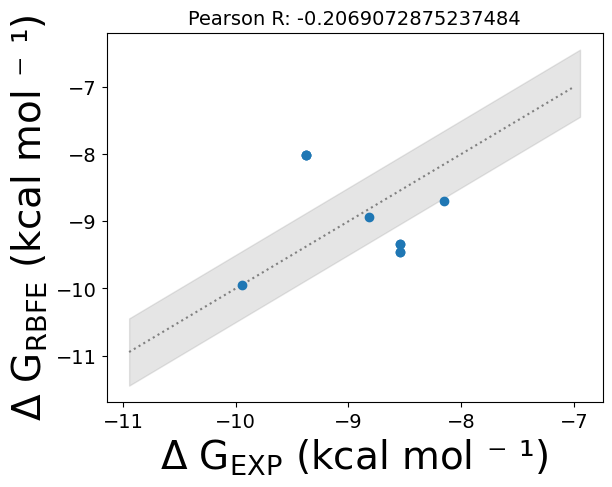

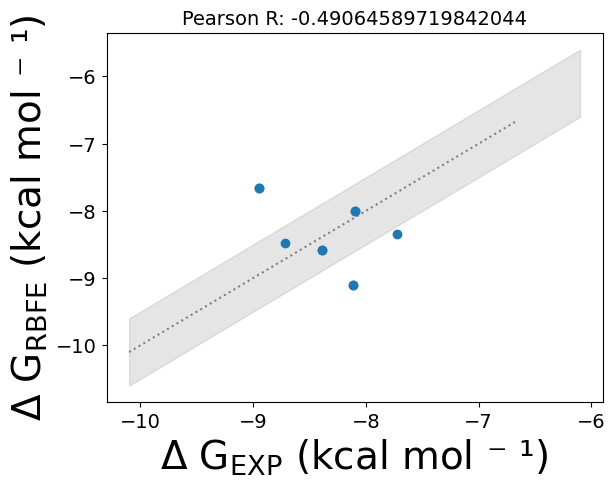

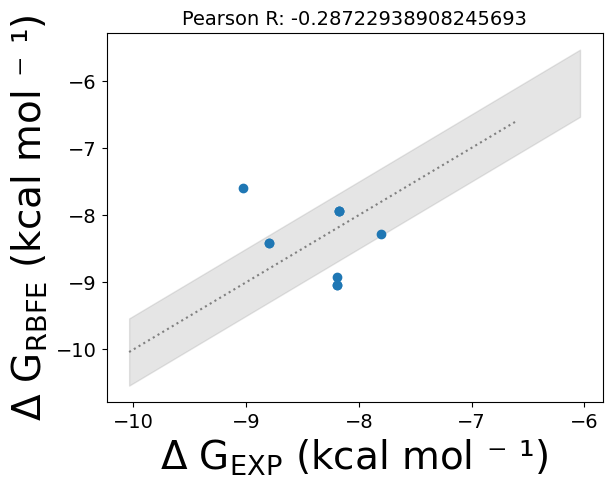

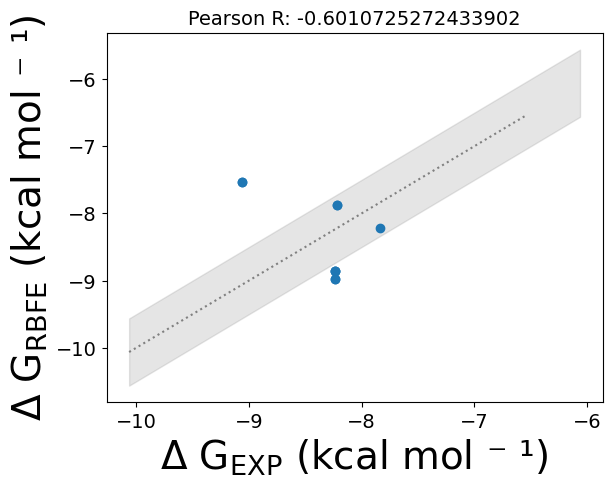

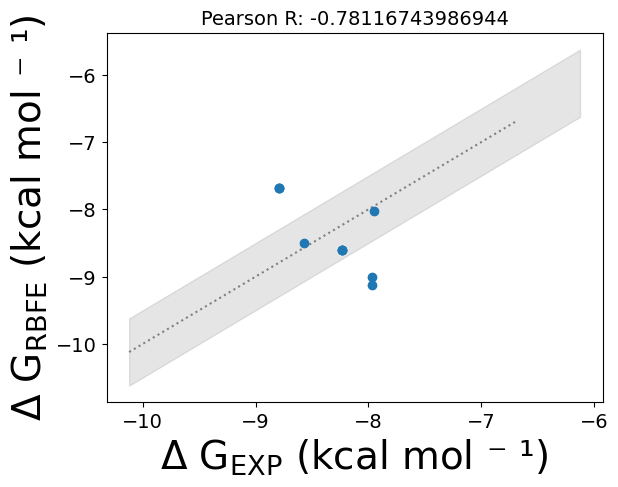

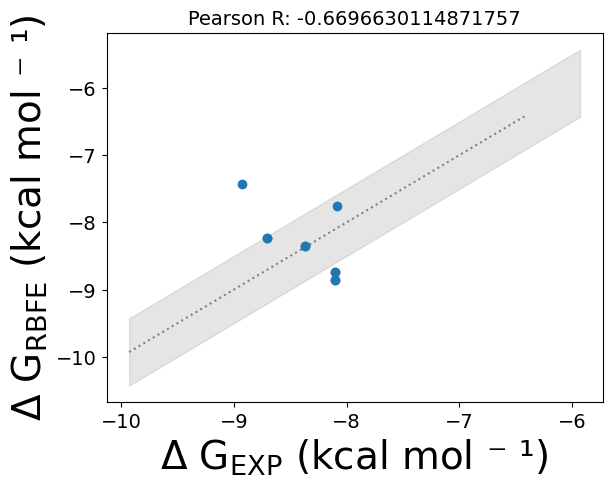

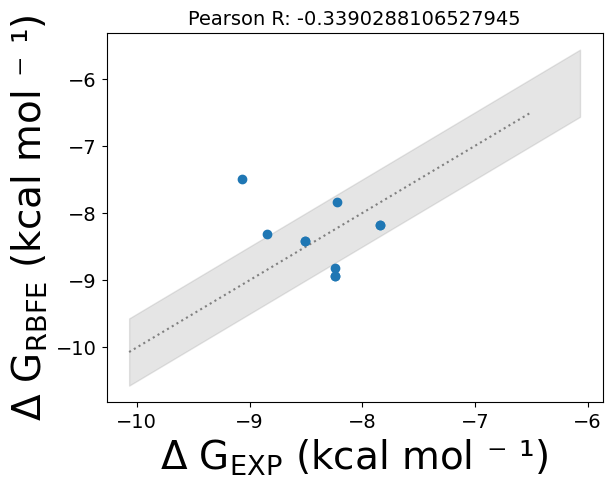

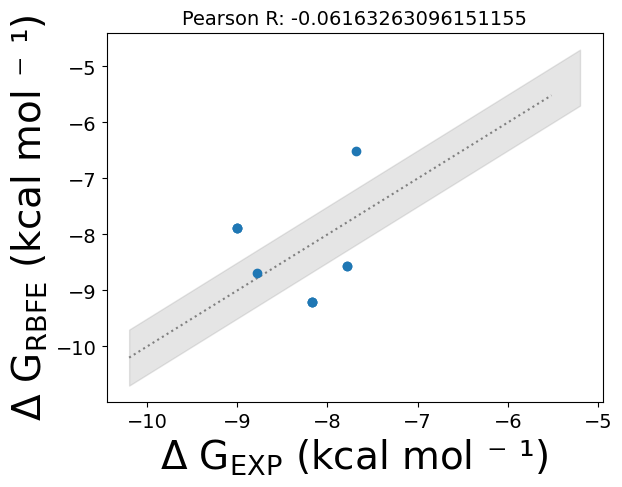

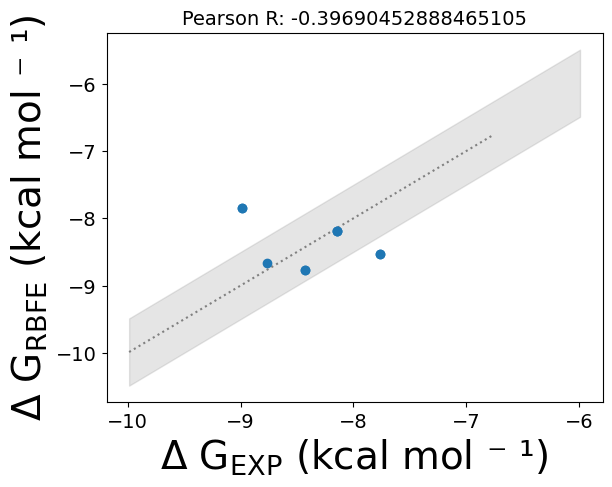

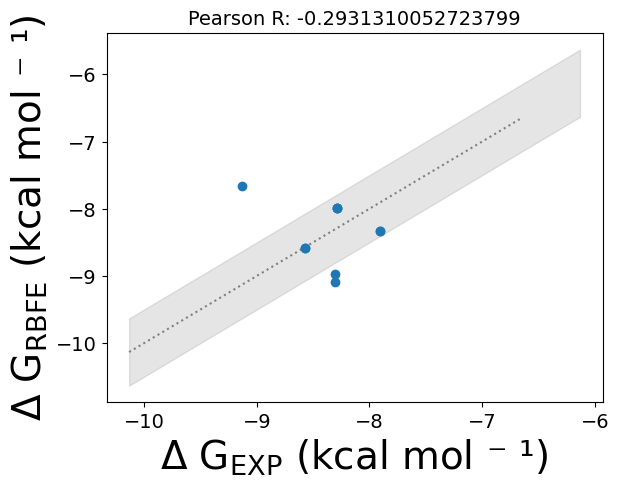

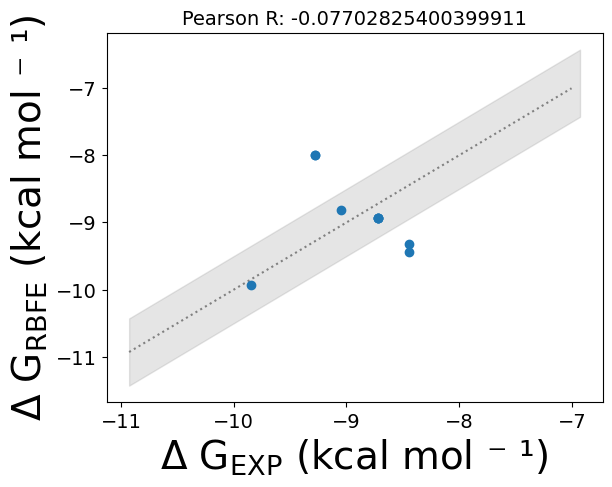

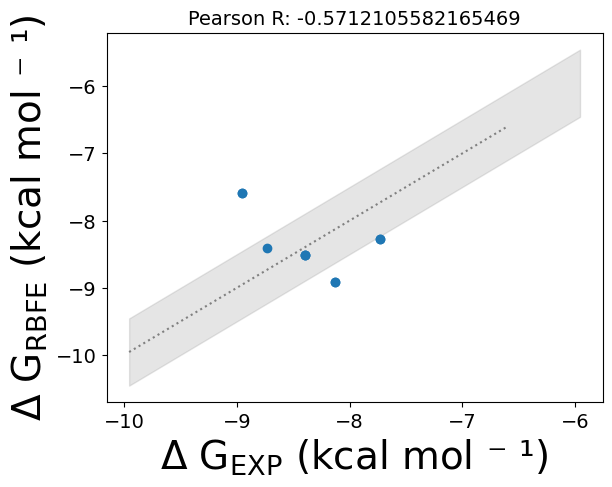

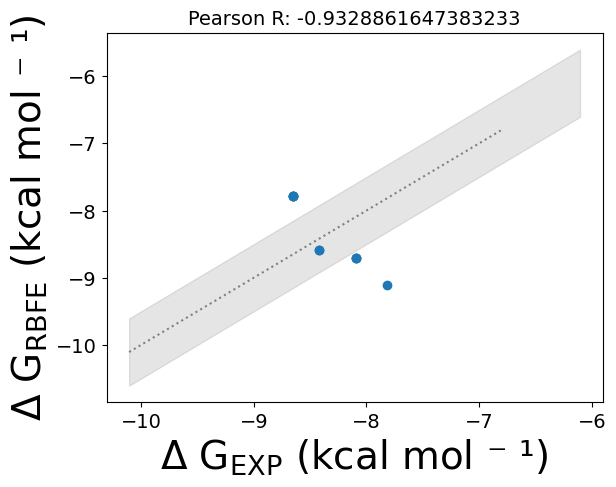

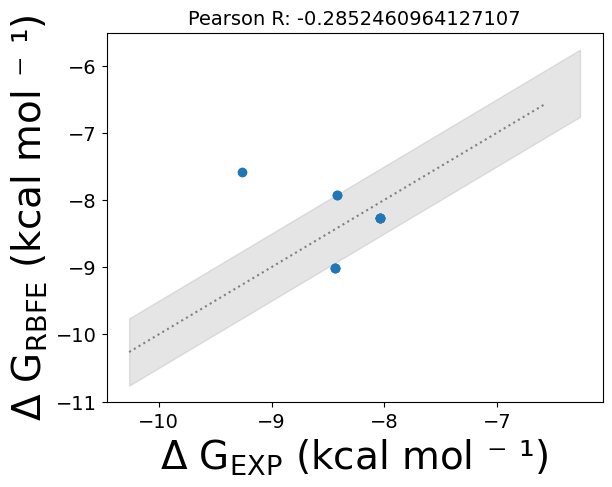

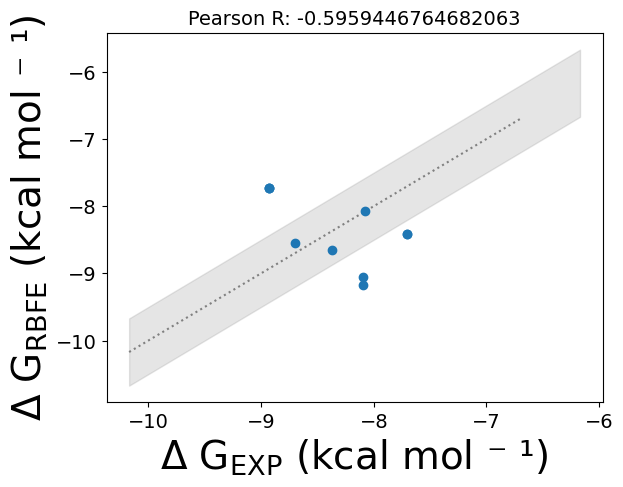

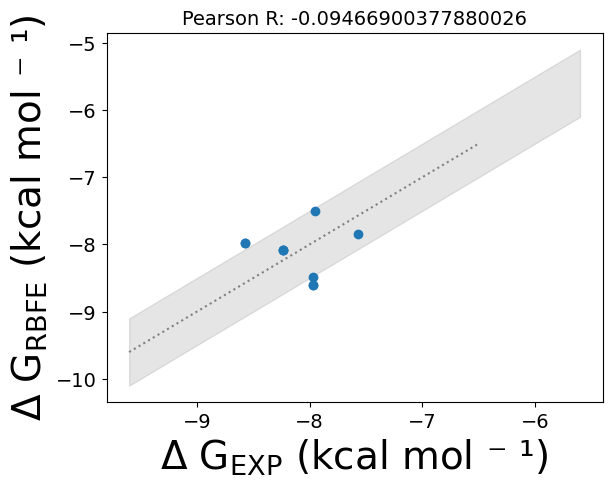

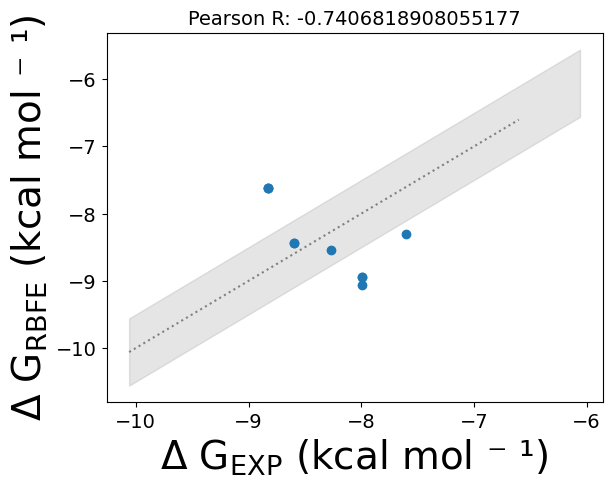

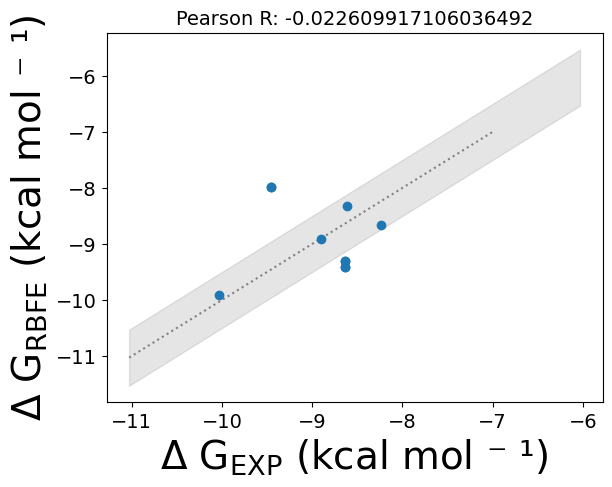

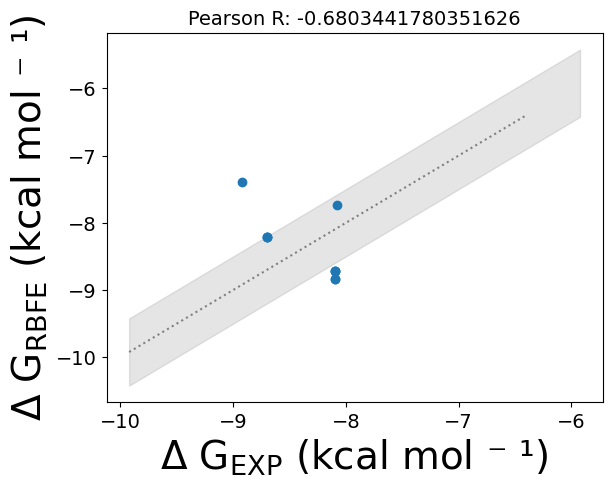

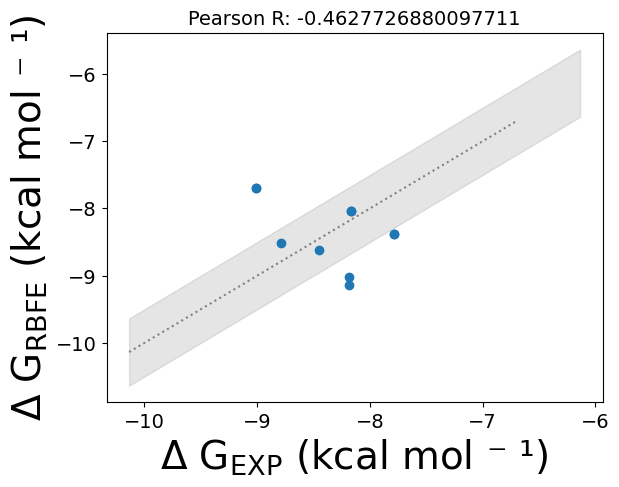

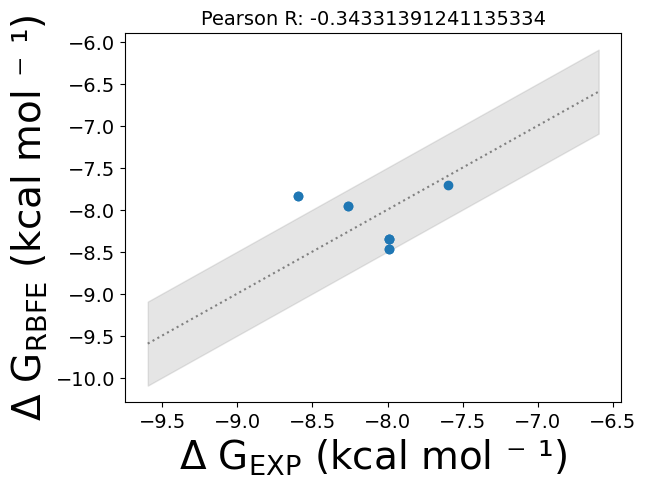

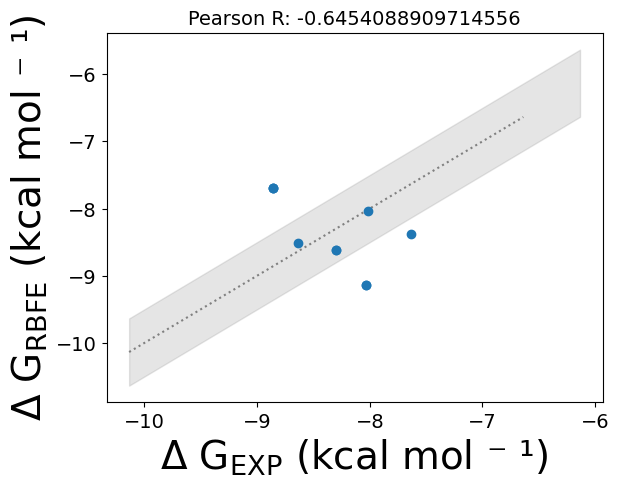

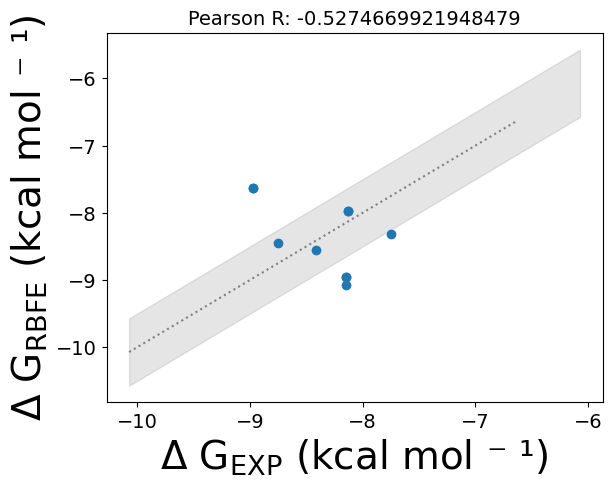

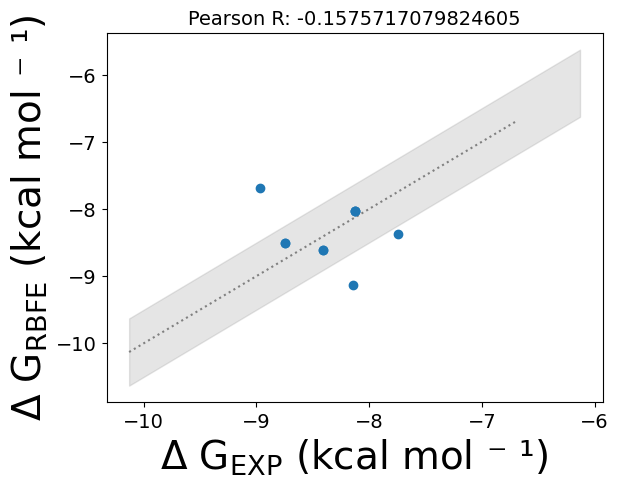

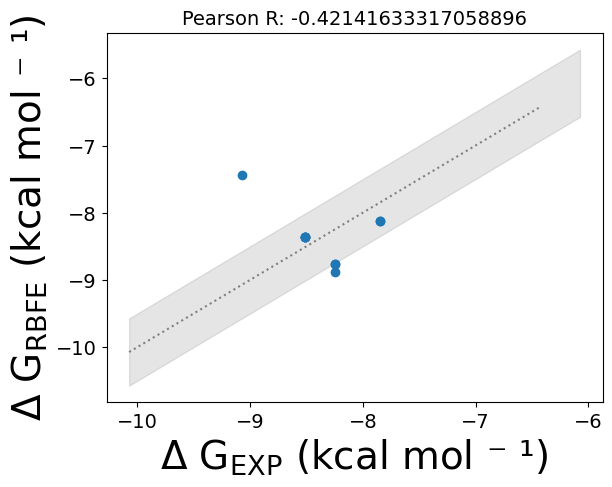

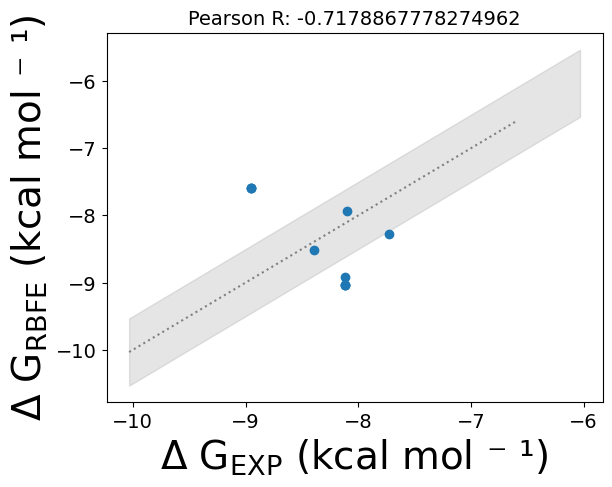

In [81]:
indices = np.where(pearson_distr < 0)[0]

for i in indices:
    exp = exp_samples[i]
    calc = calc_samples[i]
    shift = np.min(exp)
    # shift = 0
    # from https://github.com/OpenFreeEnergy/cinnabar/blob/c140fea77d4019119ed40acd1a699b92ed6bbf10/cinnabar/plotting.py#L377
    x_data = exp - np.mean(exp) + shift
    y_data = calc - np.mean(calc) + shift
    max_calculated = max(y_data) + 1 
    max_experimental = max(x_data) + 1
    max_value = max(max_calculated, max_experimental)

    min_calculated = min(y_data) - 1
    min_experimental = min(x_data) - 1
    min_value = min(min_calculated, min_experimental)
    top = np.arange(min_value+0.5, max_value+1.5)
    bottom = np.arange(min_value-0.5, max_value+0.5)
    x = np.arange(min_value, max_value+1)
    plt.fill_between(x, bottom, top, alpha=0.2, color="gray", zorder=-1)
    plt.plot([min_value, max_value], [min_value, max_value], color="gray", linestyle=":", zorder=-1)
    plt.scatter(x_data, y_data)
    plt.title(f"Pearson R: {pearson_distr[i]}")
    plt.xlabel("$\Delta$ G$_\mathrm{EXP}$ (kcal mol \u207B \u00B9)", fontsize=28)
    plt.ylabel("$\Delta$ G$_\mathrm{RBFE}$ (kcal mol \u207B \u00B9)", fontsize=28)
    plt.show()

10

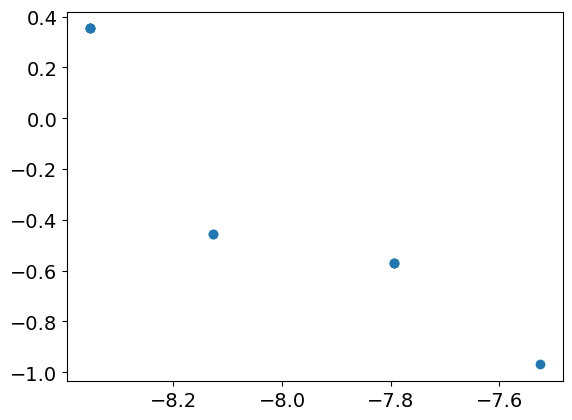

array([ 0.35321255,  0.35321255, -0.45784278, -0.45784278,  0.35321255,
        0.35321255, -0.96983043, -0.57197711, -0.57197711, -0.57197711])

## Spearman

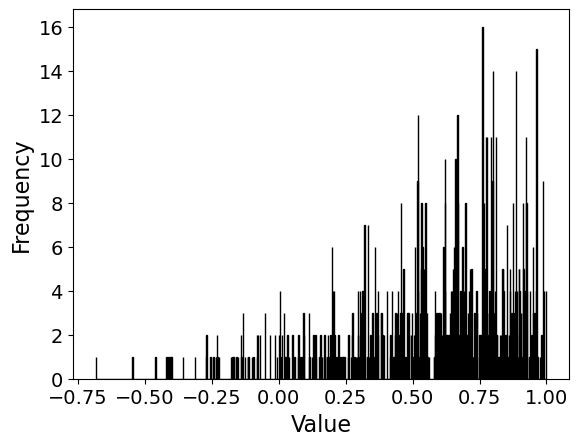

mean: 0.5812640448754001
lower: -0.16934859202819058
upper: 0.9622641509433963


In [18]:
spearman_rho_bootstrap_results = bootstrap(data=(experimental_values, calculated_values),
                                       statistic=compute_spearmanrho,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True)
distribution = spearman_rho_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution)
confidence_interval = spearman_rho_bootstrap_results.confidence_interval
plot_hist(distribution, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function**

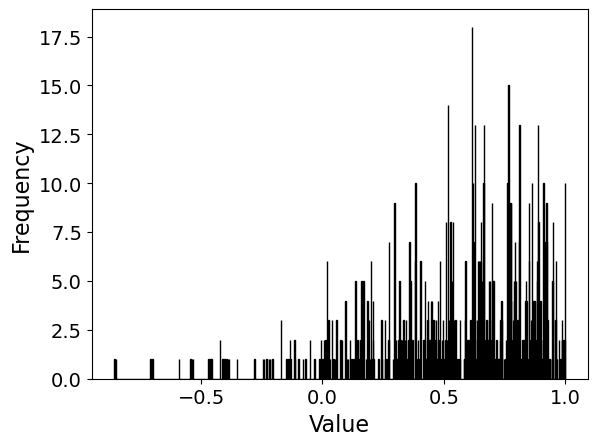

mean: 0.5670214457264321
lower: -0.23099372067457905
upper: 0.9627871283071423


In [7]:
rho_distr, rho, rho_low, rho_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## MAE

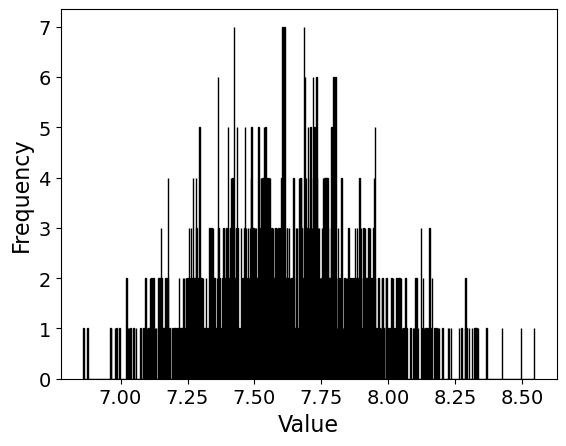

mean: 7.619390071524607
lower: 7.1109953608026055
upper: 8.16237446254835


In [8]:
mae_distr, mae, mae_low, mae_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## RMSE


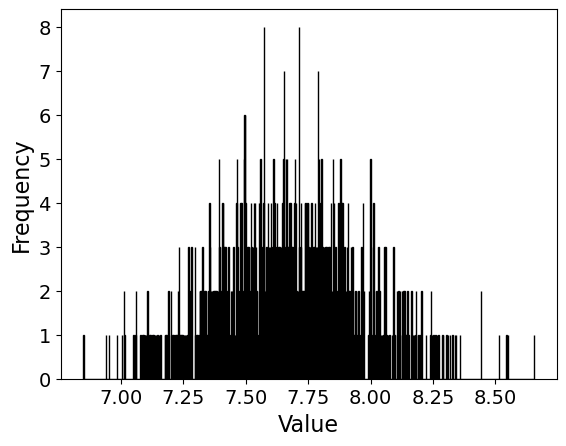

mean: 7.662839178082392
lower: 7.125339533876374
upper: 8.223194264581391


In [9]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")

# Model 0

In [19]:
working_directory = "/home/jguven/projects/alchemistry/model_0_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"


In [20]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-2.703135,0.204047
1,ligand_6,-8.354581,0.072703,0.778795,0.114841
2,ligand_8,-7.524502,0.018065,1.063872,0.130315
3,ligand_9,-8.127579,0.079488,-0.691855,0.107380
4,ligand_10,-7.524502,0.005420,0.911465,0.124754
5,ligand_11,-7.129619,0.003726,-0.304710,0.329641
6,ligand_12,-7.035065,0.001590,0.278411,0.230485
7,ligand_13,-7.506705,0.005260,0.663411,0.125475
8,ligand_15,-6.202678,0.062961,1.324241,0.181865
9,ligand_16,-8.923058,0.028299,-1.320494,0.120640


In [21]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
experimental_values = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")


### Pearson R

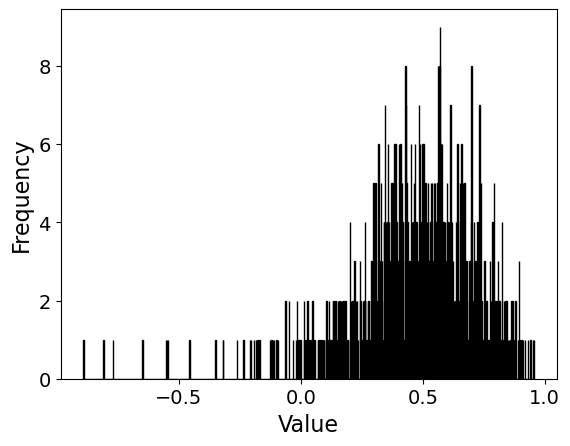

mean: 0.4703534441781236
lower: -0.0642317520682424
upper: 0.8484016407977225


In [22]:
pearsonr_bootstrap_results = bootstrap(data=(experimental_values, calculated_values),
                                       statistic=compute_pearsonr,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True)
distribution = pearsonr_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution)
confidence_interval = pearsonr_bootstrap_results.confidence_interval
plot_hist(distribution, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function**

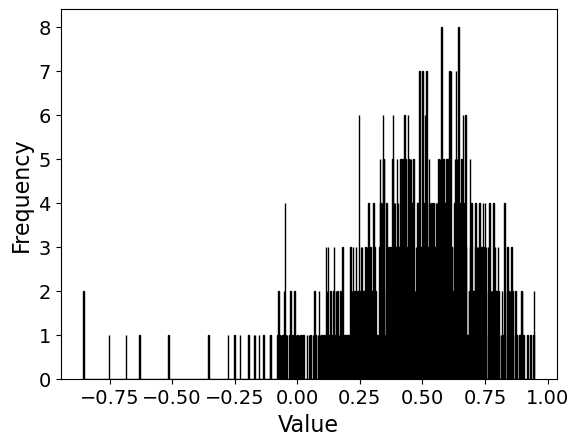

mean: 0.47381072886902026
lower: -0.05284132403065114
upper: 0.8547106359058108


In [13]:
pearson_distr, pearson, pearson_low, pearson_high = bootstrap_manual(experimental=experimental_values,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

## Spearman $\rho$

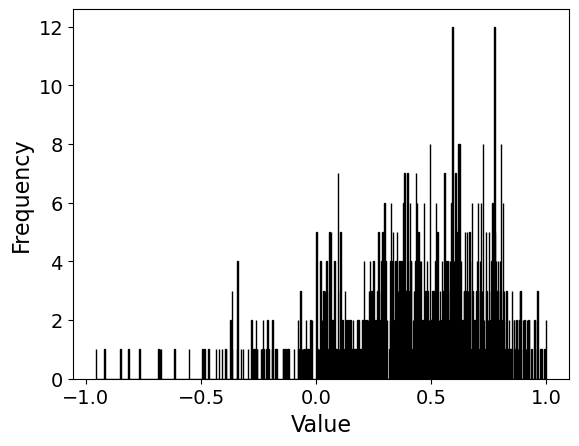

mean: 0.43253000696155774
lower: -0.3428922678455761
upper: 0.89873417721519


In [14]:
rho_distr, rho, rho_low, rho_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## Coefficient of determination (R2 score)

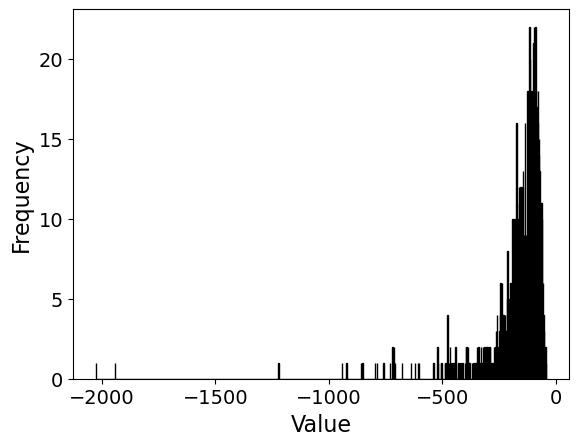

mean: -167.71722427848783
lower: -507.85753121618706
upper: -59.63840803568427


In [15]:
r2_distr, r2, r2_low, r2_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="r2",
                                              n_bootstrap_samples=1000)
plot_hist(r2_distr, n_bins=1000)
print(f"mean: {r2}")
print(f"lower: {r2_low}")
print(f"upper: {r2_high}")

## Mean absolute error

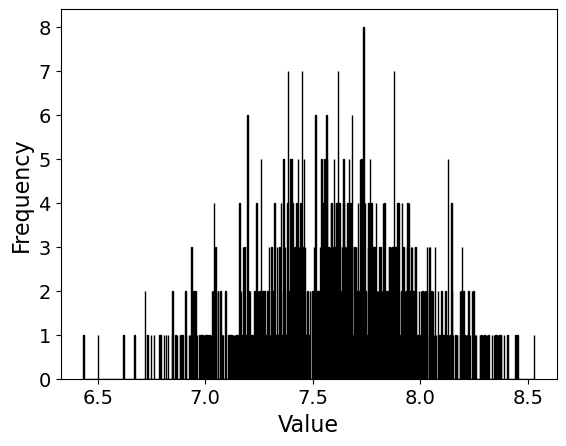

mean: 7.620563987276599
lower: 6.9243167890079285
upper: 8.250721524721945


In [16]:
mae_distr, mae, mae_low, mae_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## Root mean squared error

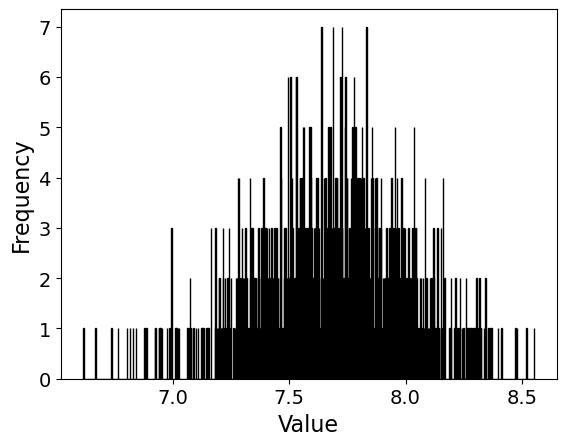

mean: 7.68287457411725
lower: 7.021588464987876
upper: 8.271858665992882


In [17]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap_manual(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")